In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io
import scipy
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import math



In [2]:
""" Define schema of datasets
"""

DATABASE = {
    'Database 1': ['female_1',
                  'female_2',
                  'female_3',
                  'male_1',
                  'male_2'],
    'Database 2': ['male_day_1',
                  'male_day_2',
                  'male_day_3']
}

COLUMNS = ['cyl_ch1', 
            'cyl_ch2', 
            'hook_ch1', 
            'hook_ch2', 
            'tip_ch1', 
            'tip_ch2', 
            'palm_ch1', 
            'palm_ch2', 
            'spher_ch1', 
            'spher_ch2', 
            'lat_ch1', 
            'lat_ch2']

LABELS = [
    'Spherical',
    'Tip',
    'Palmar',
    'Lateral',
    'Cylindrical',
    'Hook'
]

COL_MAPPINGS = {
            'cyl_ch1': 'Cylindrical', 
            'cyl_ch2': 'Cylindrical', 
            'hook_ch1': 'Hook', 
            'hook_ch2': 'Hook', 
            'tip_ch1': 'Tip', 
            'tip_ch2': 'Tip', 
            'palm_ch1': 'Palmar', 
            'palm_ch2': 'Palmar', 
            'spher_ch1': 'Spherical', 
            'spher_ch2': 'Spherical', 
            'lat_ch1': 'Lateral', 
            'lat_ch2': 'Lateral'
}

In [3]:
""" Preprocess and standardize dataset into a single dataframe table
"""

DB_NAME = 'Database 1'
dfs = []
for fname in DATABASE[DB_NAME]: 
    tmp_data = scipy.io.loadmat(f'./data/{DB_NAME}/{fname}')
    tmp_data = {k:v for k,v in tmp_data.items() if k in COLUMNS}
    for c in COLUMNS:
        tmp_dfx = pd.DataFrame(tmp_data[c])
        tmp_dfx['identifier'] = fname
        tmp_dfx['label'] = COL_MAPPINGS[c]
        dfs.append(pd.DataFrame(tmp_dfx))

dataset = pd.concat(dfs)
print("Dimensions", dataset.shape)
dataset.head()


Dimensions (1800, 3002)


,0,1,2,3,4,5,6,7,8,9,...,2992,2993,2994,2995,2996,2997,2998,2999,identifier,label
0,0.072198,0.276211,0.429221,0.327214,0.123201,0.097700,0.072198,0.021195,-0.004307,0.174205,...,0.276211,-0.259323,0.072198,1.882814,0.480224,-2.528968,0.097700,0.837247,female_1,Cylindrical
1,0.250710,0.301713,0.199706,0.378218,0.021195,-0.080812,-0.106313,0.021195,0.276211,0.072198,...,-1.304890,0.786244,0.786244,0.939254,1.270775,-0.616346,0.454723,0.021195,female_1,Cylindrical
2,0.123201,0.148703,0.148703,0.123201,-0.004307,-0.157317,-0.029808,0.174205,0.199706,0.250710,...,-0.233821,0.403719,0.046696,-0.080812,0.378218,-0.361330,0.505726,0.607732,female_1,Cylindrical
3,0.531228,-0.106313,-0.284825,-0.335828,-0.182818,0.123201,0.301713,0.352716,0.327214,-0.029808,...,0.709739,0.276211,-0.080812,0.123201,0.735241,1.270775,-0.769356,-1.687415,female_1,Cylindrical
4,-0.310326,-0.182818,0.276211,0.480224,0.352716,0.123201,0.123201,0.097700,-0.029808,-0.080812,...,-0.208320,0.429221,0.378218,0.633234,0.811746,0.403719,-0.182818,-0.412333,female_1,Cylindrical


In [4]:
#combine coupled readouts
new_dfs = []
for lab in LABELS:
    new_temp = dataset[dataset['label'] == lab].values
    new_temp_comb = pd.DataFrame(np.concatenate((new_temp[:150,:3000],new_temp[150:,:3002]),axis=1))
    new_dfs.append(new_temp_comb)


new_dataset = pd.concat(new_dfs)
new_dataset.rename(columns={6001:'label', 6000:'identifier'}, inplace=True)
print("Dimension", new_dataset.shape)
new_dataset.head()

Dimension (900, 6002)


,0,1,2,3,4,5,6,7,8,9,...,5992,5993,5994,5995,5996,5997,5998,5999,identifier,label
0,0.505726,0.531228,0.505726,0.021195,0.046696,-0.080812,0.021195,0.021195,0.123201,0.199706,...,0.227693,0.049139,-0.30797,-0.103908,0.100154,0.15117,-0.614063,-0.358985,female_3,Spherical
1,0.454723,0.174205,-0.182818,-0.386831,0.709739,0.633234,-0.029808,-0.20832,0.0977,0.582231,...,-0.333478,0.100154,0.71234,0.610309,0.559294,-0.410001,0.253201,-0.052892,female_3,Spherical
2,1.245273,0.123201,-2.273952,-2.936995,-0.335828,1.50029,1.398283,2.163332,0.403719,-0.131815,...,0.253201,-0.486524,-0.231447,-0.30797,0.100154,0.865386,0.635817,0.15117,female_3,Spherical
3,-0.080812,-0.182818,0.0977,0.123201,0.276211,0.352716,0.25071,0.199706,0.0977,-0.080812,...,0.227693,-0.818125,-0.052892,0.431755,0.457263,0.304216,0.125662,0.304216,female_3,Spherical
4,0.480224,0.021195,0.429221,0.021195,-0.004307,-0.106313,0.199706,0.199706,0.301713,0.276211,...,-0.103908,-1.124218,0.278708,0.94191,0.686832,0.023631,-1.124218,-0.333478,female_3,Spherical


In [5]:
from cgitb import Hook


def abs_val_filter(data):
    """ Apply an absolute value filter to a DataFrame
    """
    return abs(data.copy())

def butterworth_low_pass_filter(data,     
                                frequency=500,         # sampling frequency
                                lp_filter=5,           # cutoff frequency
                                order=4):
    """
    Create a low pass filter to eliminate noise and smooth EMG data 
    
    The data were collected at a sampling rate of 500 Hz, 
    using as a programming kernel the National Instruments (NI) Labview. 
    The signals were band-pass filtered using a Butterworth Band Pass filter 
    with low and high cutoff at 15Hz and 500Hz respectively and a notch filter at 50Hz 
    to eliminate line interference artifacts.
    """
    lp_filter = lp_filter/(frequency/2)

    # Create a lowpass butterworth signal 
    B, A = scipy.signal.butter(order, 
                               lp_filter, 
                               btype='lowpass')


    # Apply the lowpass signal filter to EMG data
    smooth_emg = scipy.signal.filtfilt(B, 
                                       A, 
                                       data)
    return smooth_emg


def holt_smoothing(data,
                  s_level = 0.5,
                  s_slope = 0.1):
    smoothed = Hook(data[0]).fit(smoothing_level=s_level, smoothing_slope=s_slope).fittedvalues[:]
    print(data[0])
    print(smoothed)
    return smoothed

In [6]:
df_features = new_dataset.iloc[:,:6000].copy()
df_labels = new_dataset.iloc[:, 6001]
df_features = abs_val_filter(df_features)

In [7]:
smoothed_emg_df = butterworth_low_pass_filter(df_features.to_numpy(),
                                             frequency=5000,
                                             lp_filter=25)

In [8]:
"""
X_train, X_test, y_train, y_test = train_test_split(smoothed_emg_df, 
                                                    df_labels, 
                                                    test_size=0.2, 
                                                    random_state=5)
"""

In [15]:
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

((720, 6000), (720,), (180, 6000), (180,))

In [19]:
from sklearn.preprocessing import OneHotEncoder
Y = df_labels
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [46]:
Y.shape

(900, 6)

In [20]:
# splitting data in to Train and Test
x_train, x_test, y_train, y_test = train_test_split(smoothed_emg_df, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((675, 6000), (675, 6), (225, 6000), (225, 6))

In [21]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((675, 6000), (675, 6), (225, 6000), (225, 6))

In [22]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((675, 6000, 1), (675, 6), (225, 6000, 1), (225, 6))

In [25]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import Dropout
import os
from tqdm import tqdm
import cv2
from glob import glob
import seaborn as sns
sns.set()

import sklearn
import skimage
from skimage.transform import resize

from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [24]:
from keras.layers.normalization import batch_normalization

In [30]:
model=models.Sequential()
model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(layers.Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 6000, 256)         1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3000, 256)        0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 3000, 256)         327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1500, 256)        0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 1500, 128)         163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 750, 128)        

In [27]:
from keras.callbacks import ReduceLROnPlateau

In [31]:
learning_Reduce = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[learning_Reduce])

Epoch 1/50
11/11 [==============================] - 1465s 124s/step - loss: 1.6290 - accuracy: 0.3200 - val_loss: 1.4953 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 292s 24s/step - loss: 1.4112 - accuracy: 0.3941 - val_loss: 1.4439 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 172s 15s/step - loss: 1.3130 - accuracy: 0.4222 - val_loss: 1.3525 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 121s 11s/step - loss: 1.2730 - accuracy: 0.4415 - val_loss: 1.3048 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 123s 11s/step - loss: 1.2071 - accuracy: 0.4726 - val_loss: 1.2607 - val_accuracy: 0.4489 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 130s 12s/step - loss: 1.1493 - accuracy: 0.4948 - val_loss: 1.1870 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 7/50
11/11 [==============================] - 113s 10s/step - 

In [32]:
import seaborn as sns

8/8 [==============================] - 11s 1s/step - loss: 0.9725 - accuracy: 0.6356
final overall accuracy for test :  63.555556535720825 %


<function matplotlib.pyplot.show(close=None, block=None)>

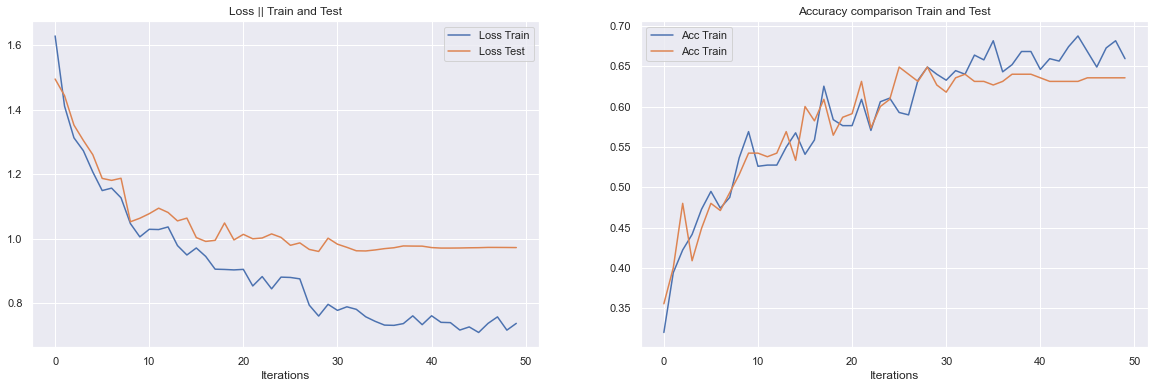

In [36]:
#from cProfile import label


print("final overall accuracy for test : ", model.evaluate(x_test, y_test)[1]*100, "%")

epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label ='Loss Train')
ax[0].plot(epochs, test_loss, label ='Loss Test')
ax[0].set_title('Loss || Train and Test')
ax[0].legend()
ax[0].set_xlabel("Iterations")

ax[1].plot(epochs, train_acc, label ='Acc Train')
ax[1].plot(epochs, test_acc, label ='Acc Train')
ax[1].set_title('Accuracy comparison Train and Test')
ax[1].legend()
ax[1].set_xlabel("Iterations")
plt.show

In [37]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [38]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,Lateral,Lateral
1,Hook,Spherical
2,Palmar,Palmar
3,Palmar,Spherical
4,Lateral,Lateral
5,Lateral,Lateral
6,Hook,Hook
7,Palmar,Palmar
8,Palmar,Palmar
9,Palmar,Tip


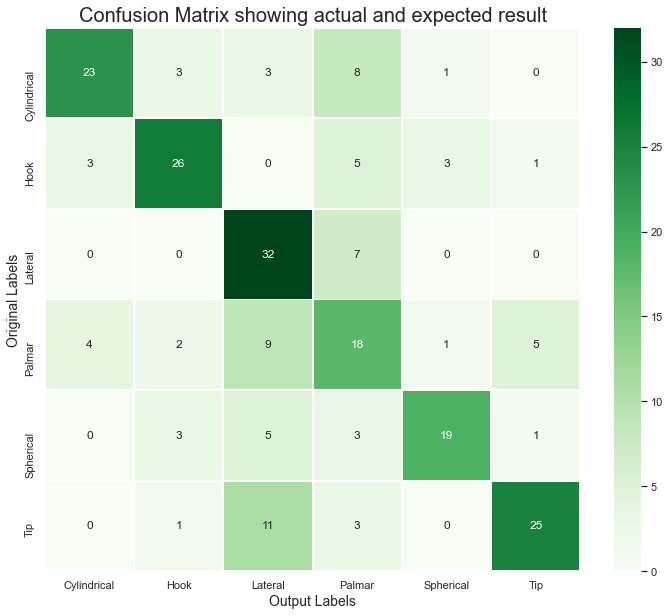

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm, index = [i for i in encoder.categories_], columns=[i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Greens', linewidths=1, annot=True, fmt="")
plt.title('Confusion Matrix showing actual and expected result', size=20)
plt.xlabel('Output Labels', size=14)
plt.ylabel('Original Labels', size=14)
plt.show()

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Cylindrical       0.77      0.61      0.68        38
        Hook       0.74      0.68      0.71        38
     Lateral       0.53      0.82      0.65        39
      Palmar       0.41      0.46      0.43        39
   Spherical       0.79      0.61      0.69        31
         Tip       0.78      0.62      0.69        40

    accuracy                           0.64       225
   macro avg       0.67      0.63      0.64       225
weighted avg       0.67      0.64      0.64       225

